## Pixyz API takes into account the features of deep generative models
- The Deep Neural Network that composes the generative model is hidden by the probability distribution
    - A framework that can separate defining DNNs and operating probability distributions(Distribution API)  
- Model types and regularization of random variables are described as objective functions(error functions)
    - A framework that receives probability distribution and define objective function(Loss API)  
- Deep generative models learn by defining objective function and using gradient descent method
    - A framework in which objective function and optimization algorithm can be set independently(Model API)
<img src="../tutorial_figs/pixyz_API.png">

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

## Overviewing relationships between  each APIs through implementing VAE

### 1. Distribution API
- A framework that can separate defining DNNs and operating probability distributions(Distribution API)
- https://pixyz.readthedocs.io/en/latest/distributions.html

<img src="../tutorial_figs/vae_graphicalmodel.png">

We define these three probability distributions

Prior: $p(z) = N(z; 0, 1)$

Generator: $p_{\theta}(x|z) = B(x; \lambda = g(z))$

Inference: $q_{\phi}(z|x) = N(z; µ = f_{\mu}(x), \sigma^2 = f_{\sigma^2}(x))$

In [2]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.utils import print_latex

#### Define prior probability distribution

prior is a gaussian distribution with mean 0 and variance 1

$p(z) = N(z; 0, 1)$

In [3]:
# prior
z_dim = 64
prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
              var=["z"], features_shape=[z_dim], name="p_{prior}").to(device)
print(prior)
print_latex(prior)

Distribution:
  p_{prior}(z)
Network architecture:
  Normal(
    name=p_{prior}, distribution_name=Normal,
    var=['z'], cond_var=[], input_var=[], features_shape=torch.Size([64])
    (loc): torch.Size([1, 64])
    (scale): torch.Size([1, 64])
  )


<IPython.core.display.Math object>

#### Define generator probability distribution
Generator is a bernoulli distribution over x given z

$p_{\theta}(x|z) = B(x; \lambda = g(z))$

Inherit pixyz.Distribution class to define a distribution with Deep neural networks

In [4]:
x_dim = 784
# generative model p(x|z)
# inherit pixyz.Distribution Bernoulli class
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(var=["x"], cond_var=["z"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
p = Generator().to(device)
print(p)
print_latex(p)

Distribution:
  p(x|z)
Network architecture:
  Generator(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )


<IPython.core.display.Math object>

#### Define Inference probability distribution

Inference is a gaussian distribution over z given x  
$\mu$ and $\sigma$ are parameterized by $\phi$

$q_{\phi}(z|x) = N(z; µ = f_{\mu}(x), \sigma^2 = f_{\sigma^2}(x))$

In [5]:
# inference model q(z|x)
# inherit pixyz.Distribution Normal class
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(var=["z"], cond_var=["x"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

q = Inference().to(device)
print(q)
print_latex(q)

Distribution:
  q(z|x)
Network architecture:
  Inference(
    name=q, distribution_name=Normal,
    var=['z'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc31): Linear(in_features=512, out_features=64, bias=True)
    (fc32): Linear(in_features=512, out_features=64, bias=True)
  )


<IPython.core.display.Math object>

#### Sampling from a probability distribution
- Sampling can be done by .sample() in defined Distribution class regardless of DNN architecture or distribution type
- In Pixyz, samples are dict type(key is variable name, value is sample)

$z\sim p(z)$

In [6]:
# z ~ p(z)
prior_samples = prior.sample(batch_n=1)
print(prior_samples)
print(prior_samples.keys())
print(prior_samples['z'].shape)

{'z': tensor([[-0.5438,  0.5853,  0.9415,  1.0591,  1.4031, -0.0520,  0.7588, -1.3387,
          0.4586,  0.2402,  0.6899, -1.4430,  0.8306,  1.6975,  0.3532, -0.3980,
         -1.5879,  0.8015, -0.7279,  1.2902,  0.6434, -0.4299, -0.0147, -0.7769,
         -0.2355,  0.8801, -0.8768, -0.0911, -0.8140, -0.2988, -0.5511, -0.1526,
         -0.1219, -0.3171, -0.2924,  0.3731,  1.8659,  1.3274,  2.4092, -0.4386,
          0.4175, -0.9096,  0.4095,  2.1348,  0.2795,  0.4564, -2.5351,  1.5394,
         -1.2816,  0.4562,  0.5690, -0.8027, -0.4947, -0.7010, -1.6218, -0.7865,
         -0.4135, -0.4891,  0.0258, -0.3843,  0.8516, -0.1511, -0.0327, -0.9058]],
       device='cuda:0')}
dict_keys(['z'])
torch.Size([1, 64])


#### Define joint distribution
- joint distribution can be difined by multiplying distributions
    - Sampling can be done by .sample()

$p_{\theta}(x, z) = p_{\theta}(x|z)p(z)$

In [7]:
p_joint = p * prior
print(p_joint)
print_latex(p_joint)

Distribution:
  p(x,z) = p(x|z)p_{prior}(z)
Network architecture:
  Normal(
    name=p_{prior}, distribution_name=Normal,
    var=['z'], cond_var=[], input_var=[], features_shape=torch.Size([64])
    (loc): torch.Size([1, 64])
    (scale): torch.Size([1, 64])
  )
  Generator(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )


<IPython.core.display.Math object>

#### Sampling from a joint distribution

$x, z \sim p_{\theta}(x, z) $

In [8]:
p_joint_samples = p_joint.sample(batch_n=1)
print(p_joint_samples)
print(p_joint_samples.keys())
print(p_joint_samples['x'].shape)
print(p_joint_samples['z'].shape)

{'z': tensor([[ 0.1798, -0.2534,  1.9239,  0.7444, -0.2541, -0.5951,  1.1151,  0.4059,
          0.5807, -0.8940, -0.7727,  0.1663, -0.0572,  2.3262,  2.4288,  1.1539,
         -1.7565, -0.0071, -0.7027,  0.9958, -0.5287, -1.2675,  0.7315,  0.6763,
          0.2179,  0.6958,  0.2657,  0.2117, -1.2440, -0.1694,  0.9022, -1.0702,
         -0.3973,  0.7750, -1.2522,  0.2898,  0.3006,  0.7156, -0.0205, -0.2505,
         -1.0893, -1.0576, -1.1959, -0.3639, -0.5362,  0.7473,  0.0541,  2.0923,
         -0.4051,  0.8123,  1.8256,  0.5847,  1.4084, -0.3716, -1.0299,  1.4635,
         -0.0438, -0.0964,  0.4627, -1.2500, -2.2660, -0.3602,  1.6857, -0.4131]],
       device='cuda:0'), 'x': tensor([[1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
         0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.

#### For more detailed Distribution API Turorial
- 01-DistributionAPITutorial.ipynb

### 2. Loss API
- A framework that receives probability distribution and define objective function(Loss API)
    - pixyz.Loss receives Distribution and defines Loss
        - Arithmetic operations can be done between Loss classes, so any Loss can be designed
            - -> Paper's formula can be put into codes easily
- Loss value is evaluated by inputting the data
    - Each Loss is treated as a symbol
        - Independent of data or DNN, we can design probabilistic model explicitly ->Define-and-run like framework

VAE Loss
$$
\mathcal { L } _ { \mathrm { VAE } } ( \theta , \phi ) =   \mathbb { E } _ { p_{data}( x ) } \left [D _ { \mathrm { KL } } \left[ q _ \phi ( z | x ) \| p ( z ) \right] - \mathbb { E } _ { q _ { \phi } ( z | x ) } \left[\log p _ { \theta } ( x | z ) \right]\right]
$$

#### Define loss using pixyz.loss

$D _ { \mathrm { KL } } \left[ q _ \phi ( z | x ) \| p ( z ) \right]$

In [9]:
from pixyz.losses import KullbackLeibler
kl = KullbackLeibler(q, prior)
print_latex(kl)

<IPython.core.display.Math object>

In [10]:
reconst = -p.log_prob().expectation(q)
print_latex(reconst)

<IPython.core.display.Math object>

#### Operations between Loss classes

In [11]:
vae_loss = (kl + reconst).mean()
print_latex(vae_loss)

<IPython.core.display.Math object>

#### Input data and loss is evaluated
- loss is calculated by .eval()

In [12]:
# dummy_x for data
dummy_x = torch.randn([4, 784]).to(device)
vae_loss.eval({"x": dummy_x})

tensor(550.8093, device='cuda:0', grad_fn=<MeanBackward0>)

#### For more detailed Loss API Turorial
- 02-LossAPITutorial.ipynb

### 3. Model API
- A framework in which objective function and optimization algorithm can be set independently
- Set loss and optimization algorithm, then train with data

In [13]:
from pixyz.models import Model
model = Model(loss=vae_loss, distributions=[p, q],
             optimizer=optim.Adam, optimizer_params={"lr": 1e-3})
print(model)
print_latex(model)

Distributions (for training):
  p(x|z), q(z|x)
Loss function:
  mean \left(D_{KL} \left[q(z|x)||p_{prior}(z) \right] - \mathbb{E}_{q(z|x)} \left[\log p(x|z) \right] \right)
Optimizer:
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [14]:
dummy_x = torch.randn([10, 784])
def train_dummy(epoch):
    global dummy_x
    dummy_x = dummy_x.to(device)
    loss = model.train({"x": dummy_x})
    print('Epoch: {} Train Loss: {:4f}'.format(epoch, loss))

In [15]:
for epoch in range(10):
    train_dummy(epoch)

Epoch: 0 Train Loss: 554.029114
Epoch: 1 Train Loss: 530.868591
Epoch: 2 Train Loss: 499.061432
Epoch: 3 Train Loss: 442.698639
Epoch: 4 Train Loss: 340.971588
Epoch: 5 Train Loss: 176.686768
Epoch: 6 Train Loss: 26.550779
Epoch: 7 Train Loss: -125.541313
Epoch: 8 Train Loss: -347.148285
Epoch: 9 Train Loss: -607.047791


#### For more detailed Model API Turorial
- 03-ModelAPITutorial.ipynb

### Training VAE with MNIST dataset

#### Install modules

In [16]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 256
epochs = 3
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


#### Prepare MNIST dataset

In [17]:
root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda x: x.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=True, transform=transform, download=True),
    shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=False, transform=transform),
    shuffle=False, **kwargs)

#### Install Pixyz modules

In [18]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler, Expectation as E
from pixyz.models import Model
from pixyz.utils import print_latex

#### Define probability distributions

In [19]:
x_dim = 784
z_dim = 64


# inference model q(z|x)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(var=["z"], cond_var=["x"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(var=["x"], cond_var=["z"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
p = Generator().to(device)
q = Inference().to(device)

prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["z"], features_shape=[z_dim], name="p_{prior}").to(device)

In [20]:
print(prior)
print_latex(prior)

Distribution:
  p_{prior}(z)
Network architecture:
  Normal(
    name=p_{prior}, distribution_name=Normal,
    var=['z'], cond_var=[], input_var=[], features_shape=torch.Size([64])
    (loc): torch.Size([1, 64])
    (scale): torch.Size([1, 64])
  )


<IPython.core.display.Math object>

In [21]:
print(p)
print_latex(p)

Distribution:
  p(x|z)
Network architecture:
  Generator(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )


<IPython.core.display.Math object>

In [22]:
print(q)
print_latex(q)

Distribution:
  q(z|x)
Network architecture:
  Inference(
    name=q, distribution_name=Normal,
    var=['z'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc31): Linear(in_features=512, out_features=64, bias=True)
    (fc32): Linear(in_features=512, out_features=64, bias=True)
  )


<IPython.core.display.Math object>

#### Define Loss

In [23]:
kl = KullbackLeibler(q, prior)
reconst = -p.log_prob().expectation(q)
vae_loss = (kl + reconst).mean()
print_latex(vae_loss)

<IPython.core.display.Math object>

#### Set optimization algorithm and model

In [24]:
model = Model(loss=vae_loss, distributions=[p, q],
             optimizer=optim.Adam, optimizer_params={"lr": 1e-3})
print(model)
print_latex(model)

Distributions (for training):
  p(x|z), q(z|x)
Loss function:
  mean \left(D_{KL} \left[q(z|x)||p_{prior}(z) \right] - \mathbb{E}_{q(z|x)} \left[\log p(x|z) \right] \right)
Optimizer:
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [25]:
def train(epoch):
    train_loss = 0
    #for x, _ in tqdm(train_loader):
    for x, _ in train_loader:
        x = x.to(device)
        loss = model.train({"x": x})
        train_loss += loss
 
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

def test(epoch):
    test_loss = 0
    #for x, _ in tqdm(test_loader):
    for x, _ in test_loader:
        x = x.to(device)
        loss = model.test({"x": x})
        test_loss += loss

    test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

#### Reconstruction

In [26]:
def plot_reconstrunction(x):
    with torch.no_grad():
        z = q.sample({"x": x}, return_all=False)
        recon_batch = p.sample_mean(z).view(-1, 1, 28, 28)
    
        comparison = torch.cat([x.view(-1, 1, 28, 28), recon_batch]).cpu()
        return comparison

#### generate images from latent variable space

In [27]:
def plot_image_from_latent(z_sample):
    with torch.no_grad():
        sample = p.sample_mean({"z": z_sample}).view(-1, 1, 28, 28).cpu()
        return sample

In [28]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Epoch: 1 Train loss: 201.0661
Test loss: 172.5077
Epoch: 1
Reconstruction


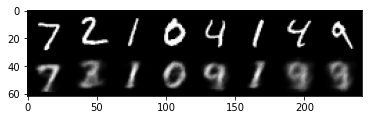

generate from prior z:


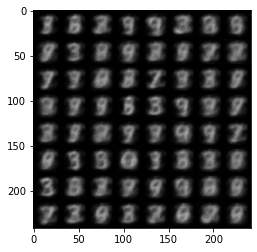

Epoch: 2 Train loss: 148.8094
Test loss: 136.5518
Epoch: 2
Reconstruction


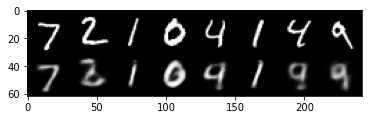

generate from prior z:


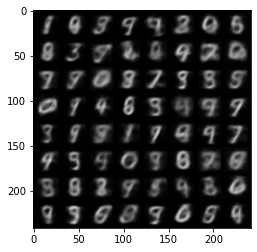

Epoch: 3 Train loss: 128.4078
Test loss: 124.8055
Epoch: 3
Reconstruction


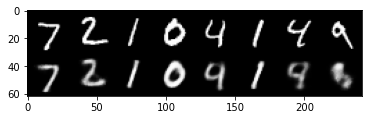

generate from prior z:


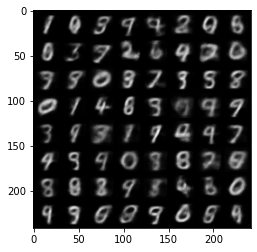

In [29]:
# z_sample for generating imgs from prior
z_sample = 0.5 * torch.randn(64, z_dim).to(device)

# fixed _x for watching reconstruction improvement
_x, _ = iter(test_loader).next()
_x = _x.to(device)

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
    recon = plot_reconstrunction(_x[:8])
    sample = plot_image_from_latent(z_sample)
    
    print('Epoch: {}'.format(epoch))
    print('Reconstruction')
    imshow(torchvision.utils.make_grid(recon))
    print('generate from prior z:')
    imshow(torchvision.utils.make_grid(sample))